In [34]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

from scripts.forecast_plot import forecast_plot

from prophet import Prophet
from prophet.plot import (
    plot_plotly,
    plot_components_plotly,
    add_changepoints_to_plot,
    plot_forecast_component,
)


In [2]:
data = pd.read_csv('data/jobathon-april-2022/train_E1GspfA.csv')
print(data.shape)
data.head()

(18247, 3)


,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [4]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = pd.to_datetime(df['date']) + df['hour'].astype('timedelta64[h]')
    df.drop('hour', axis=1, inplace=True)
    return df 

In [5]:
data = preprocess(data)
data.head()

,date,demand
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81


In [6]:
import plotly.express as px

fig = px.line(data, x='date', y='demand')
fig.show() 

In [7]:
data.head()

,date,demand
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81


In [8]:
# start_date = pd.to_datetime('2020-11-26')
start_date = pd.to_datetime('26/11/2020 22:00:00', format='%d/%m/%Y %H:%M:%S')
end_date = pd.to_datetime('2020-12-27')

data[(data['date'] >= start_date) & (data['date'] <= end_date)]

,date,demand
16826,2020-11-26 22:00:00,15
16827,2020-11-26 23:00:00,18
16828,2020-12-27 00:00:00,71


In [9]:
# filter for demand btw 90 and 100
# data[(data['demand'] >= 90) & (data['demand'] <= 100)]

In [10]:
data.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

data.head()

,ds,y
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81


In [11]:
data['ds'].dt.year.unique()

array([2018, 2019, 2020, 2021], dtype=int32)

In [12]:
data[data['ds'].dt.year.isin([2018, 2021])]

,ds,y
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81
...,...,...
18242,2021-02-28 19:00:00,95
18243,2021-02-28 20:00:00,88
18244,2021-02-28 21:00:00,39
18245,2021-02-28 22:00:00,104


In [13]:
valid_data = data[data['ds'] >= pd.to_datetime('2020-11-01')]
train_data = data[data['ds'] < pd.to_datetime('2020-11-01')]

print(f'Train data shape: {train_data.shape}')
print(f'Validation data shape: {valid_data.shape}')

Train data shape: (16254, 2)
Validation data shape: (1993, 2)


In [26]:
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(train_data)

23:05:28 - cmdstanpy - INFO - Chain [1] start processing
23:05:39 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# train_data.tail()

In [16]:
model.make_future_dataframe(periods=365).tail()

,ds
16614,2021-10-27 23:00:00
16615,2021-10-28 23:00:00
16616,2021-10-29 23:00:00
16617,2021-10-30 23:00:00
16618,2021-10-31 23:00:00


In [27]:
forecast = model.predict(valid_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1988,2021-02-28 19:00:00,102.649379,55.245824,148.721021
1989,2021-02-28 20:00:00,94.941710,52.317481,139.911640
1990,2021-02-28 21:00:00,88.243060,41.669472,135.660102
1991,2021-02-28 22:00:00,83.510406,40.060660,130.345905
1992,2021-02-28 23:00:00,80.300098,29.294708,127.602259


In [28]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (Observed)', 'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'Thanksgiving', 'Thanksgiving_lower', 'Thanksgiving_upper',
       'Veterans Day', 'Veterans Day_lower', 'Veterans Day_upper',
       'Veterans Day (Observed)', 'Veterans Day (Observed)_lower',
       'Veterans Day (Observed)_upper', 'Washington's Birthday',
       'Wash

In [19]:
forecast.shape

(1993, 88)

In [29]:
mean_absolute_error(valid_data["y"], forecast["yhat"])


31.882653476837582

In [30]:
plot_plotly(model, forecast)

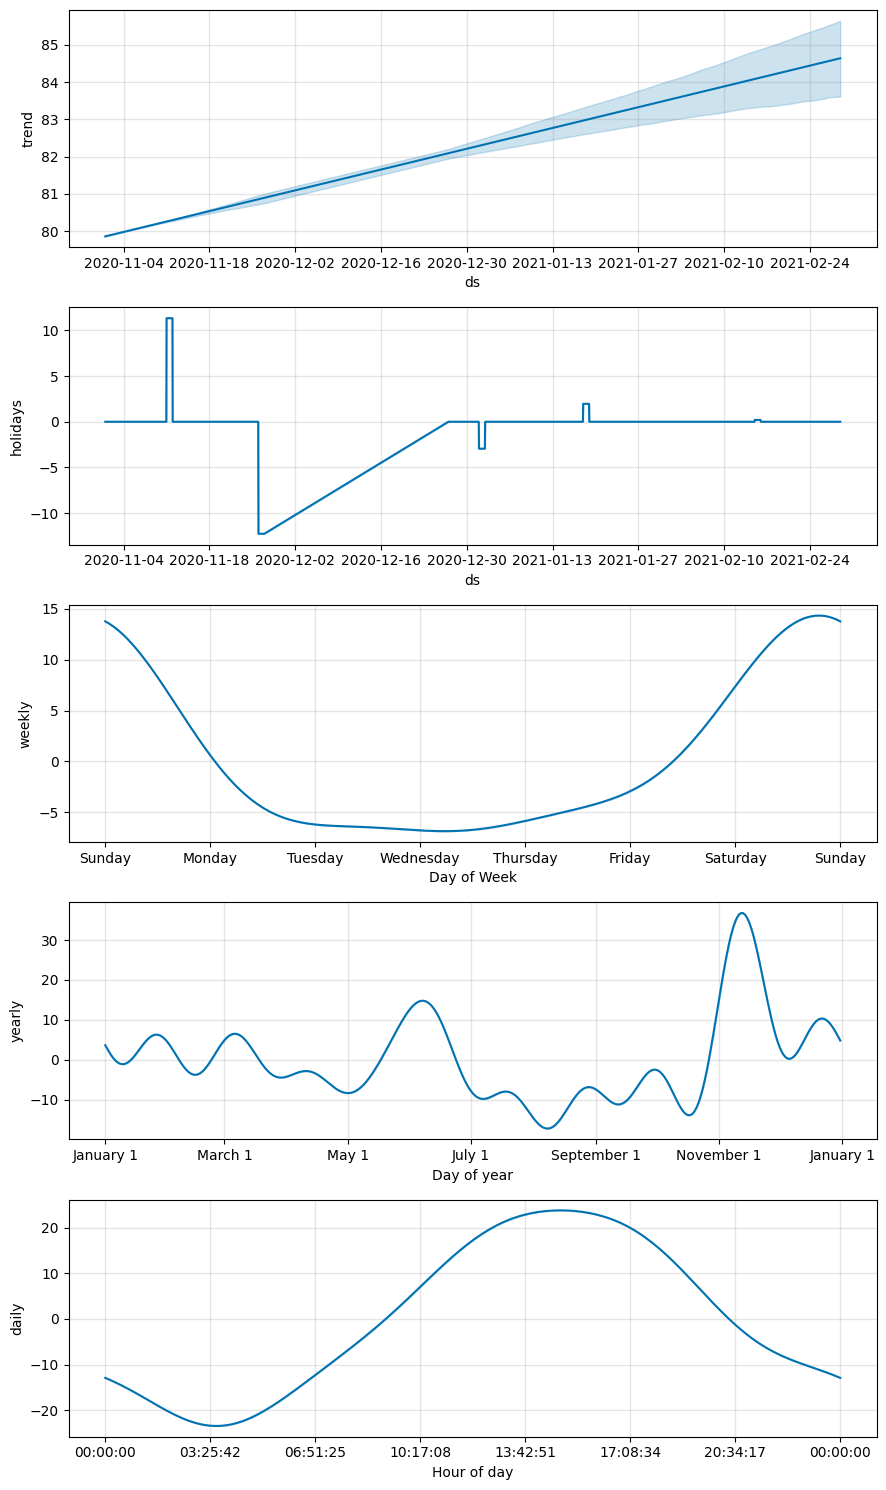

In [31]:
fig = model.plot_components(forecast)


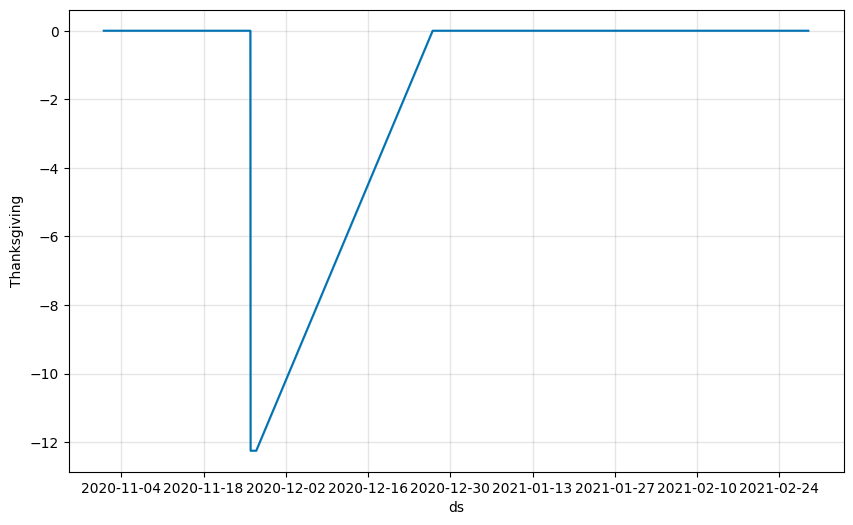

In [37]:
fig = plot_forecast_component(model, forecast, 'Thanksgiving')

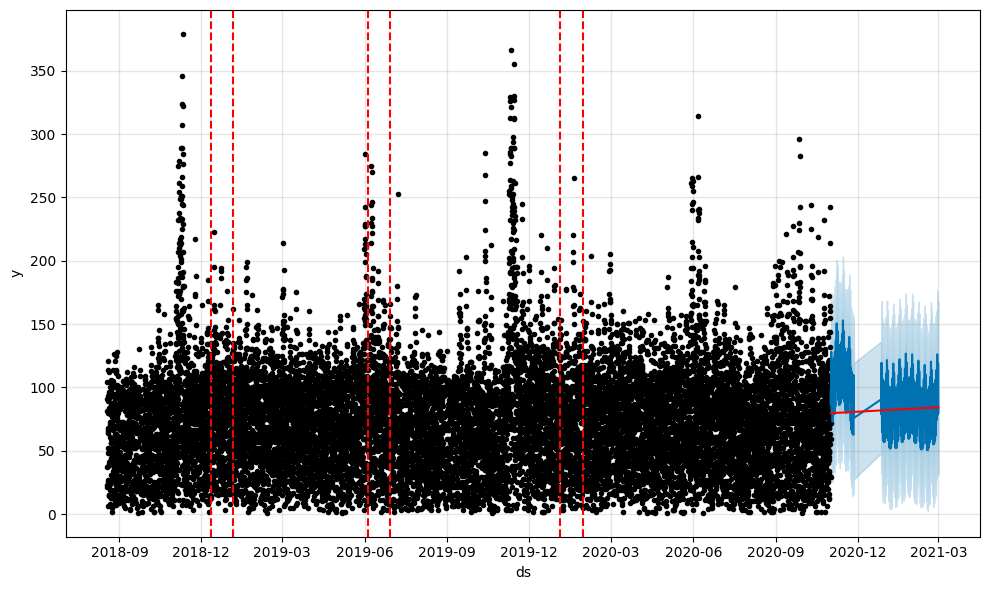

In [22]:
# Changepoints 
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)


In [23]:
model.changepoints

520     2018-09-21 09:00:00
1040    2018-10-21 21:00:00
1560    2018-11-16 02:00:00
2080    2018-12-11 11:00:00
2600    2019-01-05 08:00:00
3120    2019-01-30 16:00:00
3641    2019-02-24 16:00:00
4161    2019-03-20 17:00:00
4681    2019-04-14 19:00:00
5201    2019-05-10 18:00:00
5721    2019-06-04 18:00:00
6241    2019-06-29 10:00:00
6761    2019-07-26 23:00:00
7281    2019-08-23 08:00:00
7801    2019-09-22 14:00:00
8321    2019-10-19 11:00:00
8841    2019-11-15 11:00:00
9361    2019-12-10 23:00:00
9882    2020-01-05 00:00:00
10402   2020-01-30 07:00:00
10922   2020-02-23 12:00:00
11442   2020-03-18 13:00:00
11962   2020-04-11 09:00:00
12482   2020-05-04 22:00:00
13002   2020-05-28 15:00:00
Name: ds, dtype: datetime64[ns]

In [24]:
train_df = train_data.copy()
valid_df = valid_data.copy()

valid_df.set_index('ds', inplace=True)
train_df.set_index('ds', inplace=True)

train_df.head()

,y
ds,
2018-08-18 09:00:00,91
2018-08-18 10:00:00,21
2018-08-18 13:00:00,23
2018-08-18 14:00:00,104
2018-08-18 15:00:00,81


In [25]:
forecast_plot(
    train_df,
    valid_df,
    forecast["yhat"],
    ["Train", "Valid", "Predict"],
    "Prophet",
    "Date",
    "Demand",
)
